<a href="https://colab.research.google.com/github/Saivam/23-5-23/blob/main/gee_dtw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install folium

In [1]:
import openeo
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from dtaidistance import dtw

ModuleNotFoundError: No module named 'openeo'

In [ ]:
URL = "openeo.dataspace.copernicus.eu"  # Example URL, replace with your back-end
connection = openeo.connect(URL)

In [ ]:
# Use interactive authentication (OIDC)
connection.authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=NYHX-FJFN 📋 to authenticate.

[###################################--] ✅ Authorized successfully

Authenticated using device code flow.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [ ]:
# Define the AOI for Ongole City
aoi_ongole = {"west": 79.99, "south": 15.48, "east": 80.05, "north": 15.52}

# Set up a process to compute NDVI
ndvi_process = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=aoi_ongole,
    temporal_extent=["2020-01-01", "2022-01-01"],
    bands=["B04", "B08"]
).ndvi()

# Download the NDVI data as a GeoTIFF file
ndvi_process.download("ndvi_ongole_april_2021.tiff", format="GTiff")

In [ ]:
# Load NDVI data using rasterio
with rasterio.open("ndvi_ongole_april_2021.tiff") as src:
    ndvi_data = src.read(1)  # Assuming the NDVI data is in the first band

In [ ]:
ndvi_data

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI Map of Ongole City')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [ ]:
vegetation_threshold = 0.3
vegetation_mask = ndvi_data > vegetation_threshold

plt.figure(figsize=(10, 6))
plt.imshow(vegetation_mask, cmap='Greens')
plt.title('Vegetated Areas in Ongole City (NDVI > 0.3)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [ ]:
mean_ndvi = np.mean(ndvi_data)
print(f"Mean NDVI for Ongole City: {mean_ndvi}")

# Calculate the percentage of vegetated area (where NDVI > 0.3)
percent_vegetated = np.sum(vegetation_mask) / vegetation_mask.size * 100
print(f"Percentage of Vegetated Area: {percent_vegetated:.2f}%")

Mean NDVI for Ongole City: 0.3583167791366577
Percentage of Vegetated Area: 64.39%


In [ ]:
ndvi_time_series = np.stack(ndvi_data, axis=0)

In [ ]:
ndvi_time_series

#### **Connect and get data from GEE**

In [ ]:
import ee

# Initialize the Earth Engine module.

ee.Authenticate()
ee.Initialize(project='tough-cipher-408608')


# Define the area of interest (AOI) using coordinates for Ongole City
aoi_ee = ee.Geometry.Polygon(
    [[[79.99, 15.48],
      [79.99, 15.52],
      [80.05, 15.52],
      [80.05, 15.48]]]
)

# Function to calculate NDVI for each image in the collection
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Create an ImageCollection for Sentinel-2, filtering by date and area of interest.
collection = (ee.ImageCollection('COPERNICUS/S2')
              .filterBounds(aoi_ee)
              .filterDate('2020-01-01', '2022-01-01')
              .map(calculate_ndvi))

# Empty list to hold monthly NDVI median values
monthly_median_ndvi = []

# Loop over the years and months, calculate median NDVI, and append to list
for year in [2020, 2021]:
    for month in range(1, 13):
        # Filter collection between the first and the last day of each month
        w = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                      .filter(ee.Filter.calendarRange(month, month, 'month'))
        # Calculate the median NDVI for the filtered collection
        median = w.select('NDVI').median()
        # Extract the median NDVI value for the AOI
        value = median.reduceRegion(ee.Reducer.median(), aoi_ee, 10).get('NDVI').getInfo()
        monthly_median_ndvi.append(value)

# Print out the list of median NDVI values
print(monthly_median_ndvi)


[0.2128807883699626, 0.173872624900689, 0.1621241221675215, 0.16210420225654237, 0.14256509660107114, 0.051733639466744974, 0.1425716643284193, 0.06884448187574518, 0.09958435793139059, 0.09717213458034009, 0.20901634390453405, 0.16601328499043633, 0.23242759617762385, 0.2597662518824262, 0.2324666546488766, 0.1464787958620097, 0.1347490650096849, 0.05615156047862662, 0.08301587375099982, 0.10641817267149359, 0.08349503784026274, 0.1464528541655947, 0.009705826899883772, 0.20116206438433212]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime

# Generate a date range for the months in question
dates = pd.date_range(start='2020-01-01', end='2021-12-31', freq='M')

# Ensure the length of the NDVI list matches the number of dates
assert len(monthly_median_ndvi) == len(dates), "The number of NDVI values and dates must match."

# Create a Pandas Series with the NDVI values and dates
ndvi_series = pd.Series(monthly_median_ndvi, index=dates)

# Start plotting
plt.figure(figsize=(14, 6))

# Plot the NDVI values over time
plt.plot_date(ndvi_series.index, ndvi_series.values, 'b-', label='Monthly Median NDVI')

# Improve formatting
plt.title('Temporal NDVI Patterns in Ongole City (2020-2021)')
plt.xlabel('Date')
plt.ylabel('Median NDVI')
plt.legend()
plt.grid(True)

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gcf().autofmt_xdate()  # Auto-rotates the date labels

plt.show()


In [ ]:
region_ndvi_series = ndvi_data[50, :]

In [ ]:
from dtaidistance import dtw

# Compute DTW distance between the region's NDVI series and the reference profile
distance, _ = dtw.warping_paths(region_ndvi_series, monthly_median_ndvi, window=3, psi=1)
print(f"DTW Distance: {distance}")

DTW Distance: 4.7817812705527185


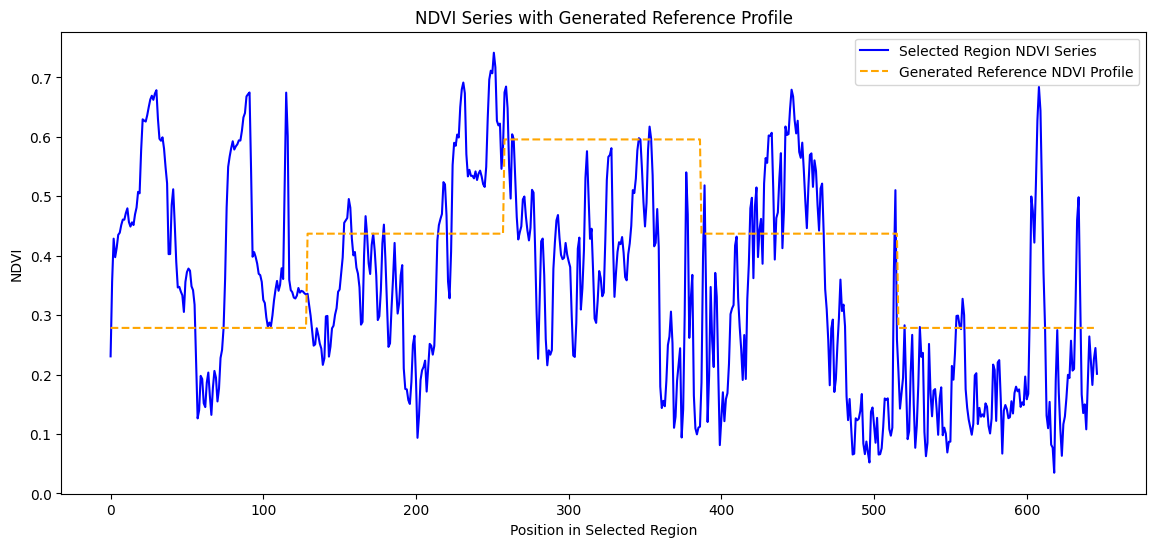

In [ ]:
import numpy as np

# Identify peaks in the NDVI series which might correspond to healthy vegetation
# We use a simple approach here to find local maxima that are above a certain threshold
healthy_vegetation_threshold = 0.5
peaks = (region_ndvi_series > healthy_vegetation_threshold) & (region_ndvi_series > np.roll(region_ndvi_series, 1)) & (region_ndvi_series > np.roll(region_ndvi_series, -1))

# Now, let's calculate the mean NDVI of these peaks to use as a reference
mean_peak_ndvi = np.mean(region_ndvi_series[peaks])

# We'll consider a simple reference profile that starts at the mean NDVI of non-vegetated areas,
# peaks at the mean NDVI of healthy vegetation, and then returns to the mean NDVI of non-vegetated areas
non_vegetated_ndvi = region_ndvi_series[region_ndvi_series < healthy_vegetation_threshold]
mean_non_vegetated_ndvi = np.mean(non_vegetated_ndvi) if len(non_vegetated_ndvi) > 0 else 0

# Create a reference profile based on these values
reference_ndvi_profile = np.array([
    mean_non_vegetated_ndvi,
    np.mean([mean_non_vegetated_ndvi, mean_peak_ndvi]),
    mean_peak_ndvi,
    np.mean([mean_non_vegetated_ndvi, mean_peak_ndvi]),
    mean_non_vegetated_ndvi
])

# Stretch the reference profile to match the length of the NDVI series for visualization
reference_profile_stretched = np.repeat(reference_ndvi_profile, length_of_series // len(reference_ndvi_profile))

# Plot the NDVI series and the generated reference profile for comparison
plt.figure(figsize=(14, 6))
plt.plot(region_ndvi_series, label='Selected Region NDVI Series', color='blue')
plt.plot(reference_profile_stretched[:length_of_series], label='Generated Reference NDVI Profile', color='orange', linestyle='--')
plt.title('NDVI Series with Generated Reference Profile')
plt.xlabel('Position in Selected Region')
plt.ylabel('NDVI')
plt.legend()
plt.show()

In [ ]:
def simple_twdtw(ndvi_pixel_series, reference_series, alpha=0.1):
    distance, _ = dtw.warping_paths(ndvi_pixel_series, reference_series, window=len(reference_series)//2)
    time_weighted_distance = distance * np.exp(-alpha * len(reference_series))
    return time_weighted_distance

In [ ]:
# Select a pixel for analysis
row, col = ndvi_time_series.shape[0] // 2, ndvi_data.shape[1] // 2
ndvi_pixel_series = ndvi_time_series[row, col]  # Assuming ndvi_data is a 2D array

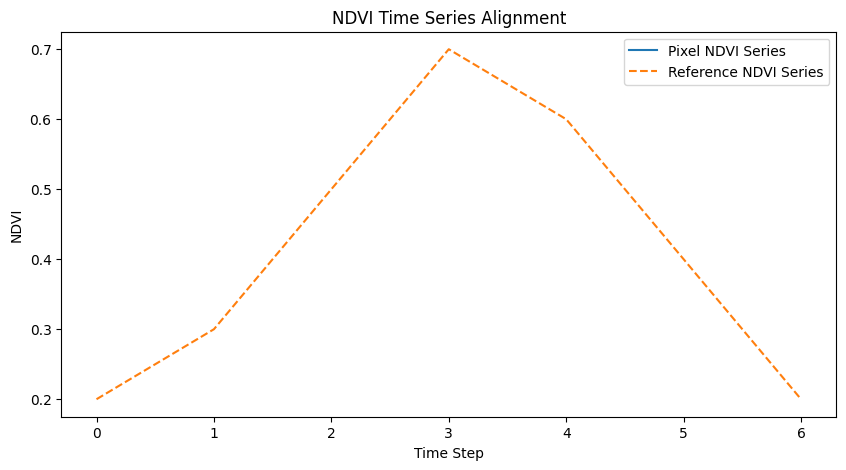

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ndvi_pixel_series, label='Pixel NDVI Series')
plt.plot(reference_ndvi, label='Reference NDVI Series', linestyle='--')
plt.legend()
plt.title('NDVI Time Series Alignment')
plt.xlabel('Time Step')
plt.ylabel('NDVI')
plt.show()


In [ ]:
!pip install dtaidistance

In [ ]:
import ee
import geopandas as gp
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np

# Initialize the Earth Engine API
ee.Authenticate()
ee.Initialize(project='tough-cipher-408608')

# Define the geometry of Ongole city
ongole_geometry = ee.Geometry.Point(80.0487, 15.5057)  # Coordinates for Ongole city

# Define the points of interest within Ongole city
point_a = ee.Geometry.Point(80.0387, 15.5157)  # Example point within Ongole city
point_b = ee.Geometry.Point(80.0587, 15.4957)  # Example point within Ongole city

In [ ]:
collection = ee.ImageCollection('COPERNICUS/S2_SR') \
                 .filterDate('2020-01-01', '2022-12-31') \
                 .filterBounds(ongole_geometry)

# Function to extract NDVI values for the points of interest
def get_ndvi_values(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).clip(ongole_geometry)
    ndvi_a = ndvi.reduceRegion(ee.Reducer.mean(), point_a, 10).get('nd')
    ndvi_b = ndvi.reduceRegion(ee.Reducer.mean(), point_b, 10).get('nd')
    return ee.Feature(None, {'ndvi_a': ndvi_a, 'ndvi_b': ndvi_b})

# Map the function over the image collection
ndvi_values = collection.map(get_ndvi_values)

# Convert the lists to NumPy arrays
ndvi_a_list = []
ndvi_b_list = []
for feature in ndvi_values.getInfo()['features']:
    ndvi_a = feature['properties']['metadata']['dictionaryValue']['values']['ndvi_a']['functionInvocationValue']['arguments']['dictionary']['functionInvocationValue']['arguments']['output']['constantValue']
    ndvi_b = feature['properties']['metadata']['dictionaryValue']['values']['ndvi_b']['functionInvocationValue']['arguments']['dictionary']['functionInvocationValue']['arguments']['output']['constantValue']
    if ndvi_a is not None and ndvi_b is not None:
        ndvi_a_list.append(ndvi_a)
        ndvi_b_list.append(ndvi_b)

# Create flat, 1-dimensional arrays
ndvi_a_array = np.array(ndvi_a_list).ravel()
ndvi_b_array = np.array(ndvi_b_list).ravel()

# Apply DTW and visualize the results
d, paths = dtw.warping_paths(ndvi_a_array, ndvi_b_array, window=20, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(ndvi_a_array, ndvi_b_array, paths, best_path)

path = dtw.warping_path(ndvi_a_array, ndvi_b_array)
dtwvis.plot_warping(ndvi_a_array, ndvi_b_array, path)

KeyError: 'metadata'